In [1]:
pip install magent2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 81.1 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pettingzoo==1.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.4/823.4 kB 12.1 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pettingzoo
    Found existing installation: pettingzoo 1.24.0
    Uninstalling pettingzoo-1.24.0:
      Successfully uninstalled pettingzoo-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.9 requires pettingzoo==1.24.0, but you have pettingzoo 1.22.0 which is incompatible.
magent2 0.3.3 requires pettingzoo>=1.23.1, but you have pettingzoo 1.22.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
torch.autograd.set_detect_anomaly(True)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from magent2.environments import battle_v4
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
from collections import deque
import random

# --- Noisy Linear Layer ---

class NoisyLinear(nn.Module):
    """
    implements noisy linear layer with factorized Gaussian noise parameters.
    used for exploration in Deep Q-networks instead of epsilon-greedy.
    input: Regular linear layer parameters
    output: Linear transformation with added parameterized noise
    """
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon = epsilon_out.ger(epsilon_in).to(self.weight_mu.device) # Create new tensors instead of in-place copy
        self.bias_epsilon = epsilon_out.to(self.bias_mu.device) # Create new tensors instead of in-place copy

    def forward(self, input):
        if self.training:
            return nn.functional.linear(input, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
        else:
            return nn.functional.linear(input, self.weight_mu, self.bias_mu)


In [5]:

# --- Dueling Q-Network with Noisy Layers ---

class DuelingQNetwork(nn.Module):
    """
    neural network implementing Dueling architecture with Noisy layers.
    separates state value and advantage functions.
    uses noisy linear layers for exploration.
    input: game state observation
    output: Q-values for each action
    """
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1).unsqueeze(0)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc_value = nn.Sequential(
            NoisyLinear(flatten_dim, 128),
            nn.ReLU(),
            NoisyLinear(128, 1)
        )

        self.fc_advantage = nn.Sequential(
            NoisyLinear(flatten_dim, 128),
            nn.ReLU(),
            NoisyLinear(128, action_shape)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.cnn(x)
        x = x.reshape(x.size(0), -1)
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

    def reset_noise(self):
        for module in self.children():
          for layer in module:
            if isinstance(layer, NoisyLinear):
                layer.reset_noise()


In [6]:

# --- Hypernetwork-based VDN Mixer ---

class HyperVDNMixer(nn.Module):
    """
    value decomposition network using hypernetworks to mix agent Q-values.
    combines individual agent values into team value using dynamic weights.
    input: Individual agent Q-values and states  
    output: Team Q-value
    """
    def __init__(self, n_agents, hypernet_embed=64):
        super().__init__()
        self.n_agents = n_agents
        self.embed_dim = hypernet_embed

        # Hypernetwork layers
        self.hyper_w_1 = nn.Sequential(
            nn.Linear(self.n_agents, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.n_agents)  # Outputting weights for the first layer
        )
        self.hyper_w_final = nn.Linear(self.n_agents, 1)  # Outputting weights for the final layer

    def forward(self, agent_qs, states):
        # State embedding (using agent's positions as a simple state representation)
        agent_positions = states.mean(dim=(2,3))[:,:self.n_agents]
        # First layer
        w1 = torch.abs(self.hyper_w_1(agent_positions))
        b1 = torch.mean(agent_qs,dim=1,keepdim=True)
        hidden = nn.functional.elu(torch.bmm(agent_qs.view(-1, 1, self.n_agents), w1.view(-1, self.n_agents, 1)) + b1)

        # Second layer
        w_final = torch.abs(self.hyper_w_final(agent_positions))
        y = torch.bmm(hidden, w_final.view(-1, 1, 1))

        # Reshape and return
        q_total = y.view(-1, 1, 1)
        return q_total


In [10]:
class RedQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

In [7]:

# --- Prioritized Replay Buffer ---

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        self.pos = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        beta = self.beta_start + (1.0 - self.beta_start) * self.frame / self.beta_frames
        self.frame = min(self.frame + 1, self.beta_frames)

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        state, action, reward, next_state, done = zip(*samples)
        return state, action, reward, next_state, done, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio.item()  # Convert to a standard Python number
        self.max_priority = max(self.max_priority, max(batch_priorities, default=self.max_priority).item())

    def __len__(self):
        return len(self.buffer)


In [11]:
def evaluate_checkpoint(q_network, red_q_network, pretrain_policy, num_episodes=5):
    env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)
    total_steps = 0
    total_rewards_random = 0
    total_rewards_pretrained = 0

    for _ in range(num_episodes):
        # --- Evaluate against random policy ---
        observations = env.reset()
        done_agents = set()
        episode_reward_random = 0
        while True:
            actions = {}
            red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
            blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

            if red_agents:
                for agent in red_agents:
                    actions[agent] = env.action_spaces[agent].sample()  # Random action

            if blue_agents:
                states_blue = torch.stack([
                    torch.tensor(observations[agent], dtype=torch.float32)
                    for agent in blue_agents
                ]).to(device)
                with torch.no_grad():
                    q_network_blue.reset_noise()          
                    q_values_blue = q_network(states_blue)
                    selected_actions_blue = torch.argmax(q_values_blue, dim=1)

                for idx, agent in enumerate(blue_agents):
                    actions[agent] = selected_actions_blue[idx].item()

            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done_agents.update([agent for agent, terminated in terminations.items() if terminated])
            observations = next_obs
            episode_reward_random += sum(rewards.get(agent, 0.0) for agent in blue_agents)
            if all(terminations.values()) or all(truncations.values()):
                total_rewards_random += episode_reward_random
                break

        # --- Evaluate against pretrained policy ---
        observations = env.reset()
        done_agents = set()
        episode_reward_pretrained = 0
        while True:
            actions = {}
            red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
            blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

            if red_agents:
                for agent in red_agents:
                    actions[agent] = pretrain_policy(env, agent, observations[agent])  # Pretrained action

            if blue_agents:
                states_blue = torch.stack([
                    torch.tensor(observations[agent], dtype=torch.float32)
                    for agent in blue_agents
                ]).to(device)
                with torch.no_grad():
                    q_network_blue.reset_noise() 
                    q_values_blue = q_network(states_blue)
                    selected_actions_blue = torch.argmax(q_values_blue, dim=1)

                for idx, agent in enumerate(blue_agents):
                    actions[agent] = selected_actions_blue[idx].item()

            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done_agents.update([agent for agent, terminated in terminations.items() if terminated])
            observations = next_obs
            episode_reward_pretrained += sum(rewards.get(agent, 0.0) for agent in blue_agents)
            if all(terminations.values()) or all(truncations.values()):
                total_rewards_pretrained += episode_reward_pretrained
                break

    avg_reward_random = total_rewards_random / num_episodes
    avg_reward_pretrained = total_rewards_pretrained / num_episodes
    avg_reward = (avg_reward_random + avg_reward_pretrained) / 2

    return avg_reward, avg_reward_random, avg_reward_pretrained

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- TensorBoard writer ---

log_dir = os.path.join("runs", "Noisy_Dueling_VDN_PER_HyperMixer_BattleV4_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)

# --- Initialize the environment ---

env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)

sample_observation = env.observation_spaces[env.agents[0]].shape
state_space = sample_observation
action_space = env.action_spaces[env.agents[0]].n
n_agents = len([agent for agent in env.agents if agent.startswith("blue_")])

# --- Initialize networks and optimizers ---

q_network_blue = DuelingQNetwork(state_space, action_space).to(device)
target_network_blue = DuelingQNetwork(state_space, action_space).to(device)
target_network_blue.load_state_dict(q_network_blue.state_dict())
target_network_blue.eval()

vdn_mixer_blue = HyperVDNMixer(n_agents).to(device)

optimizer_blue = optim.Adam(list(q_network_blue.parameters()) + list(vdn_mixer_blue.parameters()), lr=0.0005)

# --- Hyperparameters ---
gamma = 0.99
num_episodes = 500
max_steps_per_episode = 1000
checkpoint_interval = 5
polyak_tau = 0.005
replay_buffer_size = 500000
batch_size = 4096
num_val_episodes = 5
# --- Initialize replay buffers ---

replay_buffer_blue = PrioritizedReplayBuffer(replay_buffer_size)
red_q_network = RedQNetwork(state_space, action_space).to(device)  # Assuming same architecture
red_q_network.load_state_dict(torch.load("/kaggle/input/redpt/other/default/1/red.pt", map_location=device))
red_q_network.eval()

def pretrain_policy(env, agent, obs):
    observation = (torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device))
    with torch.no_grad():
        red_q_values = red_q_network(observation)
    return torch.argmax(red_q_values, dim=1).cpu().numpy()[0]
    
# --- Training loop ---

best_val = -float('inf')
best_checkpoint = ""
torch.autograd.set_detect_anomaly(False) # Turn off after debugging
for episode in range(0, num_episodes + 1):
    observations = env.reset()
    
    # --- Reset noise in the networks at the beginning of each episode
    q_network_blue.reset_noise()
    target_network_blue.reset_noise()
    
    total_reward_blue = 0
    done_agents = set()

    for step in range(max_steps_per_episode):
        actions = {}
        red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
        blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

        # --- Random actions for red agents ---
        if red_agents:
            for agent in red_agents:
                actions[agent] = np.random.randint(0, action_space)

        # --- Process all blue agents ---
        if blue_agents:
            states_blue = torch.stack([
                torch.tensor(observations[agent], dtype=torch.float32)
                for agent in blue_agents
            ]).to(device)

            # --- Select actions ---
            with torch.no_grad():
                q_values_blue = q_network_blue(states_blue)
                selected_actions_blue = torch.argmax(q_values_blue, dim=1)

            for idx, agent in enumerate(blue_agents):
                actions[agent] = selected_actions_blue[idx].item()

        # --- Take step in environment ---
        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        # --- Update total rewards ---
        total_reward_blue += sum(rewards.get(agent, 0.0) for agent in blue_agents)

        for agent in blue_agents:
            # Handle cases where next_obs might not be available for done agents
            next_state = next_obs.get(agent) if not terminations.get(agent, False) else observations[agent]

            replay_buffer_blue.push(
                observations[agent],
                actions[agent],
                rewards.get(agent, 0.0),
                next_state,
                terminations.get(agent, False)
            )

        # --- Update done_agents based on terminations ---
        done_agents.update([agent for agent, terminated in terminations.items() if terminated])

        # --- Train blue network on a batch sampled from replay buffer ---
        if len(replay_buffer_blue) >= batch_size:
            state_batch, action_batch, reward_batch, next_state_batch, done_batch, indices, weights = replay_buffer_blue.sample(batch_size)
            
            current_states_blue = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
            current_actions_blue = torch.tensor(action_batch, dtype=torch.long).to(device)
            next_states_blue = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
            rewards_blue = torch.tensor(reward_batch, dtype=torch.float32).to(device)
            dones_blue = torch.tensor(done_batch, dtype=torch.float32).to(device)
            weights_tensor_blue = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device)
            
            # Reset noise outside of torch.no_grad()
            q_network_blue.reset_noise()
            target_network_blue.reset_noise()

            current_q_values_blue = q_network_blue(current_states_blue).gather(1, current_actions_blue.unsqueeze(1))

            with torch.no_grad():
              next_actions_blue = q_network_blue(next_states_blue).max(1, keepdim=True)[1]
              target_q_values_blue = target_network_blue(next_states_blue).gather(1, next_actions_blue)

            
            rewards_blue = rewards_blue.unsqueeze(1)
            dones_blue = dones_blue.unsqueeze(1)
            
            target_q_values_blue = rewards_blue + gamma * target_q_values_blue * (1 - dones_blue)

            td_errors = (target_q_values_blue - current_q_values_blue).abs().detach().cpu().numpy()
            new_priorities = td_errors + 1e-6
            replay_buffer_blue.update_priorities(indices, new_priorities)

            loss_blue = (weights_tensor_blue * nn.SmoothL1Loss(reduction='none')(current_q_values_blue, target_q_values_blue)).mean()

            optimizer_blue.zero_grad()
            loss_blue.backward()
            nn.utils.clip_grad_norm_(list(q_network_blue.parameters())+ list(vdn_mixer_blue.parameters()), 1.0)
            optimizer_blue.step()

            writer.add_scalar('Loss/Blue', loss_blue.item(), episode * max_steps_per_episode + step)

        # --- Soft update target networks ---
        for target_param, param in zip(target_network_blue.parameters(), q_network_blue.parameters()):
            target_param.data.copy_(polyak_tau * param.data + (1 - polyak_tau) * target_param.data)

        observations = next_obs

        # Check for episode termination (either all terminated or max_cycles reached)
        if all(terminations.values()) or (truncations and all(truncations.values())):
            break

    # --- Log episode statistics ---

    writer.add_scalar('Total Reward/Blue', total_reward_blue, episode)
    print(f"Episode {episode}/{num_episodes}, Total Reward Blue: {total_reward_blue:.2f}")

    # --- Save checkpoints and evaluate ---

    if episode % checkpoint_interval == 0:
      checkpoint_path = f"blue_agent_noisy_dueling_vdn_per_hypermixer_ep{episode}.pth"
      torch.save({
          'q_network_blue_state_dict': q_network_blue.state_dict(),
          'vdn_mixer_blue_state_dict': vdn_mixer_blue.state_dict(),
      }, checkpoint_path)
      val_reward, val_reward_random, val_reward_pretrained = evaluate_checkpoint(q_network_blue, red_q_network, pretrain_policy, num_val_episodes)
      writer.add_scalar('Validation/Average Reward', val_reward, episode)
      writer.add_scalar('Validation/Average Reward vs Random', val_reward_random, episode)
      writer.add_scalar('Validation/Average Reward vs Pretrained', val_reward_pretrained, episode)
      print(f"Episode {episode}: Validation average reward = {val_reward:.2f}, "
              f"vs Random = {val_reward_random:.2f}, vs Pretrained = {val_reward_pretrained:.2f}")
      if val_reward >= best_val:
            best_val = val_reward
            if best_checkpoint:
                os.remove(best_checkpoint)
            best_checkpoint = checkpoint_path
            print(f"New best checkpoint saved at {best_checkpoint}")
      if val_reward < best_val:
            os.remove(checkpoint_path)
if best_checkpoint:
    best_checkpoint_final = "blue_agent_noisy_dueling_vdn_hypermixer_best.pth"
    os.rename(best_checkpoint, best_checkpoint_final)
    print(f"Training complete. Best model saved at {best_checkpoint_final}")
else:
    torch.save({
        'q_network_blue_state_dict': q_network_blue.state_dict(),
        'vdn_mixer_blue_state_dict': vdn_mixer_blue.state_dict(),
    }, "blue_agent_noisy_dueling_vdn_hypermixer_final.pth")
    print(f"Training complete. Final model saved at blue_agent_noisy_dueling_vdn_per_hypermixer_final.pth")

Using device: cuda


/tmp/ipykernel_23/2465235017.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  red_q_network.load_state_dict(torch.load("/kaggle/input/redpt/other/default/1/red.pt", map_

Episode 0/500, Total Reward Blue: -1473.56
Episode 0: Validation average reward = -1195.79, vs Random = -2241.79, vs Pretrained = -149.79
New best checkpoint saved at blue_agent_noisy_dueling_vdn_per_hypermixer_ep0.pth
Episode 1/500, Total Reward Blue: -861.90
Episode 2/500, Total Reward Blue: -427.90
Episode 3/500, Total Reward Blue: 43.19
Episode 4/500, Total Reward Blue: -77.02
Episode 5/500, Total Reward Blue: 364.45
Episode 5: Validation average reward = 3.06, vs Random = -18.90, vs Pretrained = 25.03
New best checkpoint saved at blue_agent_noisy_dueling_vdn_per_hypermixer_ep5.pth
Episode 6/500, Total Reward Blue: -36.42
Episode 7/500, Total Reward Blue: -567.98
Episode 8/500, Total Reward Blue: 316.08
Episode 9/500, Total Reward Blue: 350.91
Episode 10/500, Total Reward Blue: 319.34
Episode 10: Validation average reward = 200.05, vs Random = 356.47, vs Pretrained = 43.62
New best checkpoint saved at blue_agent_noisy_dueling_vdn_per_hypermixer_ep10.pth
Episode 11/500, Total Reward

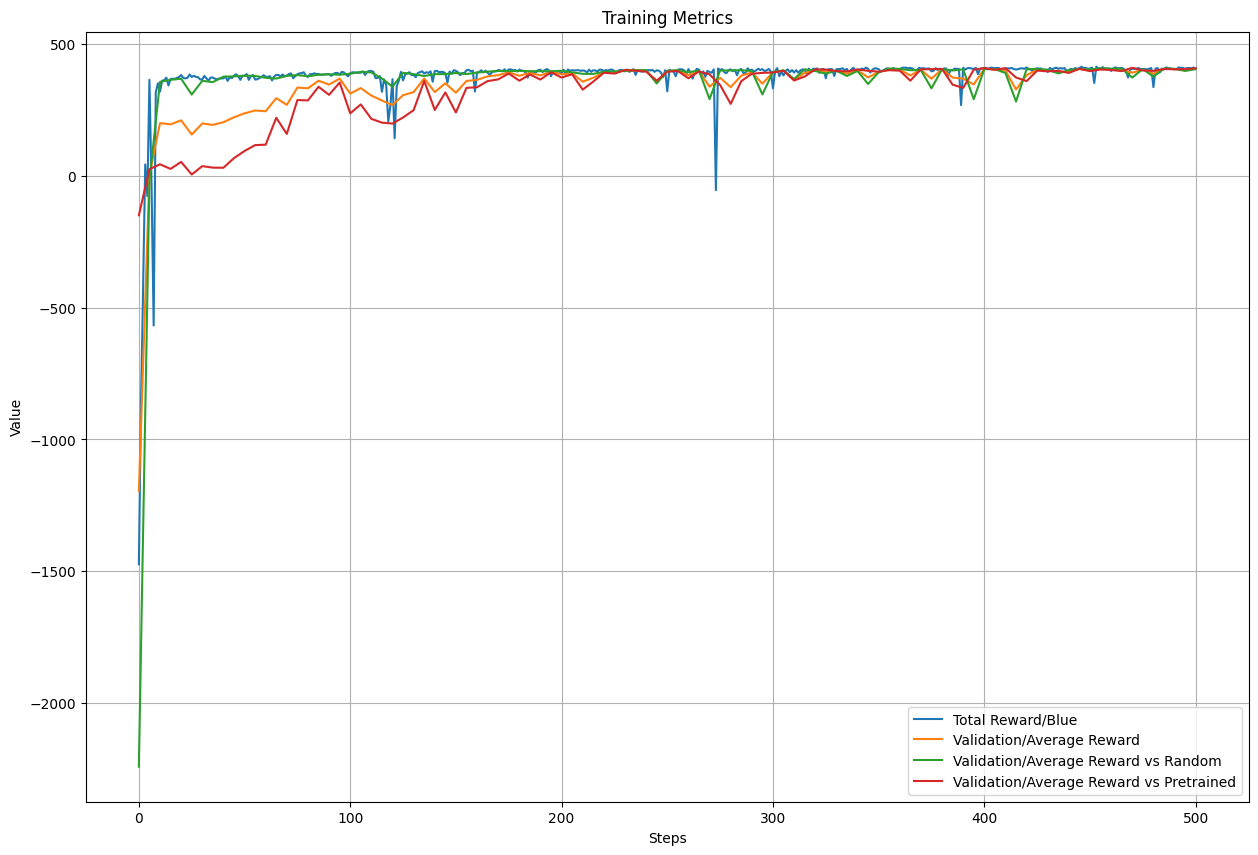

In [18]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# --- Function to extract data from TensorBoard logs ---
def extract_data_from_logs(log_dir, tags):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    data = {tag: [] for tag in tags}

    for tag in tags:
        events = event_acc.Scalars(tag)
        for event in events:
            data[tag].append((event.step, event.value))

    return data

# --- Set log directory ---
log_dir = "/kaggle/working/runs"
latest_run = max([os.path.join(log_dir, d) for d in os.listdir(log_dir)], key=os.path.getmtime)

# --- Tags to plot ---
tags_to_plot = ['Total Reward/Blue','Validation/Average Reward','Validation/Average Reward vs Random','Validation/Average Reward vs Pretrained']
data = extract_data_from_logs(latest_run, tags_to_plot)

# --- Plot data ---
plt.figure(figsize=(15, 10))
for tag in tags_to_plot:
    steps, values = zip(*data[tag])
    plt.plot(steps, values, label=tag)

plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.show()
